# Electrochemical based battery model
##### Copyright © 2021 United States Government as represented by the Administrator of the National Aeronautics and Space Administration.  All Rights Reserved.


This notebook contains a detailed explanation of a battery model implemetaiton with the equations used in the implementation. The developers of this script used the paper `M. Daigle and C. Kulkarni, "Electrochemistry-based Battery Modeling for Prognostics," Annual Conference of the Prognostics and Health Management Society 2013, pp. 249-261, New Orleans, LA, October 2013.` https://papers.phmsociety.org/index.php/phmconf/article/view/2252. The paper adopted an electrochemical based battery modeling approach.

Before going into the details of the implementaiton, here is a figure that illustrates how the chemical energy is converted to electrical energy inside of a single cell battery. For Li-ion, a common chemistry is a positive electrode consisting of lithium cobalt oxide $(Li_xCoO_2)$ and negative electrode of lithiated carbon $(Li_xC)$. When fully charged, the active (mobile) Li-ions reside in the negative electrode. Upon connecting a load to the battery, current is allowed to flow from the positive to the negative electrode.

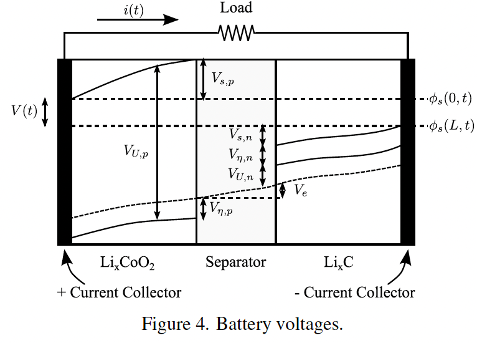

In the above figure, 

* $V_{U,p}$ represents the **equilibrium potential at positive current collector,** 
* $V_{U,n}$ represents the **equilibrium potential at negative current collector,**
* $V_{s,p}$ represents the **voltage drop due to the solid-phase resistance at positive electrode,**
* $V_{s,n}$ represents the **voltage drop due to the solid-phase resistance at negative electrode,**
* $V_{\eta,p}$ represents the **surface over-potential at positive electrode,**
* $V_{\eta,n}$ represents the **surface over-potential at negative electrode,**
* $V_{e}$ represents the **voltage drop due to electrolyte ohmic resistance**

Now, let us first import all the necessary packages and declate the constants of nature

In [15]:
from prognostics_model import PrognosticsModel
import numpy as np
import pandas as pd
from math import asinh, log, inf
from copy import deepcopy

# Constants of nature
R = 8.3144621  # universal gas constant, J/K/mol
F = 96487      # Faraday's constant, C/mol
R_F = R / F    # Optimization - R / F
mC = 37.04 # kg/m2/(K-s^2)
tau = 100


The mole fraction (the fraction of Li-ions that exist in either electrodes wrt the total Li-ion charge) can be computed using the equation (eqn (8) in the paper): 

$$x_i = \frac{q_i}{q^{max}} $$

where, $q_i$ represents the amount of Li ions in electrode $i$, and $q^{max}$ is the maximum amount of Li-ion that exists in a cell.

In [11]:
def update_qmax(params):
    # note qMax = qn+qp
    return {
        'qMax': params['qMobile']/(params['xnMax']-params['xnMin'])
    }


# set up charges (Li ions)
def update_qpmin(params):
    # min charge at pos electrode
    return {
        'qpMin': params['qMax']*params['xpMin'] 
    }

def update_qpmax(params):
    # max charge at pos electrode
    return {
        'qpMax': params['qMax']*params['xpMax'] 
    }

def update_qnmin(params):
    # min charge at negative electrode
    return {
        'qnMin': params['qMax']*params['xnMin'] 
    }

def update_qnmax(params):
    # max charge at negative electrode
    return {
        'qnMax': params['qMax']*params['xnMax'] 
    }



In both sides of the electrodes (anode and cathode), the volumen of the cell can be devided in to Bulk volume and surface layer - as depicted in the following figure.
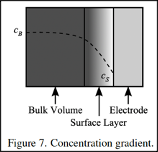

The concentration gradient of the Li ions changes in a non-linear manner in the two volumes and the following block implementes the equations to calculate amount of Li ions that exists in the bulk and surface layers. 

$$q_p = q_{s,p} + q_{b,p}$$
$$q_n = q_{s,n} + q_{b,n}$$
$$q^{max} = q_{s,p} + q_{b,p} + q_{s,n} + q_{b,n}$$ 

In [10]:
def update_vols(params):
    # Volumes (total volume is 2*P.Vol), assume volume at each electrode is the
    # same and the surface/bulk split is the same for both electrodes
    return {
        'VolS': params['VolSFraction']*params['Vol'],
        'VolB': params['Vol']*(1.0-params['VolSFraction'])
    }
def update_qpSBmin(params):
    # min charge at surface and bulk pos electrode
    return {
        'qpSMin': params['qMax']*params['xpMin']*params['VolSFraction'],
        'qpBMin': params['qMax']*params['xpMin']*(1.0-params['VolSFraction']),
        'x0': {
            **params['x0'],
            'qpS': params['qMax']*params['xpMin']*params['VolSFraction'],
            'qpB': params['qMax']*params['xpMin']*(1.0-params['VolSFraction'])
        }
    }

def update_qpSBmax(params):
    # max charge at surface and pos electrode
    return {
        'qpSMax': params['qMax']*params['xpMax']*params['VolSFraction'],
        'qpBMax': params['qMax']*params['xpMax']*(1.0-params['VolSFraction'])
    }

def update_qnSBmin(params):
    # min charge at surface and bulk pos electrode
    return {
        'qnSMin': params['qMax']*params['xnMin']*params['VolSFraction'],
        'qnBMin': params['qMax']*params['xnMin']*(1.0-params['VolSFraction'])

    }

def update_qnSBmax(params):
    # max charge at surface and pos electrode
    return {
        'qnSMax': params['qMax']*params['xnMax']*params['VolSFraction'],
        'qnBMax': params['qMax']*params['xnMax']*(1.0-params['VolSFraction']),
        'x0': {
            **params['x0'],
            'qnS': params['qMax']*params['xnMax']*params['VolSFraction'],
            'qnB': params['qMax']*params['xnMax']*(1.0-params['VolSFraction'])
        }
    }

def update_qSBmax(params):
    # max charge at surface, bulk (pos and neg)
    return {
        'qSMax': params['qMax']*params['VolSFraction'],
        'qBMax': params['qMax']*(1.0-params['VolSFraction']),
    }



  ##  Prognostics model for end of discharge (EOD)

This class implements an Electro chemistry model as described in the paper. The default model parameters included are for Li-ion batteries, specifically 18650-type cells. Experimental discharge curves for these cells can be downloaded from the `Prognostics Center of Excellence Data Repository https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/`.

### Concentration overpotential
is a potential difference that is caused by difference in concentration between the two concentration volumes (CV). And it is given by the equation:  


$$V_{U,i} = U_0 + \frac{RT}{nF}ln \Big(\frac{1 - x_{s,i} }{x_{s,i}} \Big) + V_{INT,i} $$

$$V_{INT,i} = \frac{1}{nF} \Big( \sum_{k=0}^{N_i} A_{i,k} \Big( (2x_i - 1)^{k+1} - \frac{2x_ik(1-x_i)}{(2x_i -1)^{1-k}} \Big) \Big) $$

In the above equation, $U_0$ is the reference potential, $R$ is the universal gas constant, $T$ is the electrode temperature, $n$ is the number of electrons transferred in the reaction ($n=1$ for Li-ion), $F$ is Faraday's constant, $x_{s,i}$ is the mole fraction at the surface.

### Ohmic overpotential
The voltage drops due to the solid-phase ohmic resistances, the electrolyte ohmic resistance, and the resistances at the current collectors.

$$V_0 = V_{s,p} + V_{s,n} + V_e + V_{cc,p} + V_{cc,n} $$

### Surface overpotential 
The overpotentials due to charge transfer resistance and Solid-electrolyte interface (SEI) kinetics are described by the Butler-Volmer equation. 
$$J_i = \frac{i}{S_i} $$

$$J_{i0} = k_i(1 - x_{s,i})^{\alpha} (x_{s,i})^{1-\alpha} $$

$$V_{\eta,i} = \frac{RT}{F\alpha}arc\sinh \Big(\frac{J_i}{2J_{i0}} \Big) $$

In the above equations, $J_i$ is the current density, $k_i$ is a lumped parameter of several constants including a rate coefficient, electrolyte concentration, and maximum ion concentration. And $S_i$ is the surface area of both CVs


Events: (1)
  * EOD: End of Discharge

Inputs/Loading: (1)
  * i: Current draw on the battery

States: (8)
* tb: Battery temperature (K)
* Vo: Voltage Drops due to Solid-Phase Ohmic Resistances
* Vsn: Negative Surface Voltage (V)
* Vsp: Positive Surface Voltage (V)
* qnB: Amount of Negative Ions at the Battery Bulk
* qnS: Amount of Negative Ions at the Battery Surface
* qpB: Amount of Positive Ions at the Battery Bulk
* qpS: Amount of Positive Ions at the Battery Surface

Outputs/Measurements: (2)
* t: Temperature of battery (°C) 
* v: Voltage supplied by battery



In [13]:
class BatteryElectroChemEOD(PrognosticsModel):
    events = ['EOD']
    inputs = ['i']
    states = ['tb', 'Vo', 'Vsn', 'Vsp', 'qnB', 'qnS', 'qpB', 'qpS']
    outputs = ['t', 'v']

    default_parameters = {  # Set to defaults
        'qMobile': 80387,
        'xnMax': 0.6,
        'xnMin': 0,
        'xpMax': 1.0,
        'xpMin': 0.4,
        'Ro': 0.0232,
        
        # Li-ion parameters
        'alpha': 0.5,
        'Sn': 2.6452e-19,
        'Sp': 0.6867,
        'kn': 1.7715e-29,
        'kp': 260520,
        'Vol': 1.2000e-04,
        'VolSFraction': 0.6,

        # time constants
        'tDiffusion': 9.2139e+04,
        'to': 9.0276,
        'tsn': 3.1184e+04,
        'tsp': 2.0911,

        # Redlich-Kister parameters (+ electrode)
        'U0p': 24.4559,
        'Ap': [-269531, 0.4040, 168533, -563091, 63508, 2561180, 200182, -7825330, 1.2296e+04, 6861830, 2028170, -990957, -2602390],

        # Redlich-Kister parameters (- electrode)
        'U0n': 0.0522,
        'An': [422.3000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],

        'x0': {
            'Vo': 0,
            'Vsn': 0,
            'Vsp': 0,
            'tb': 292.1  # in K, about 18.95 C
        },

        'process_noise': 1e-3,

        # End of discharge voltage threshold
        'VEOD': 18.0, 
        'VDropoff': 0.1 # Voltage above EOD after which voltage will be considered in SOC calculation
    }

    state_limits = {
        'tb': (0, inf),  # Limited by Absolute Zero (0 K)
        'qnB': (0, inf),
        'qnS': (0, inf),
        'qpB': (0, inf),
        'qpS': (0, inf)
    }

    param_callbacks = {  # Callbacks for derived parameters
        'qMobile': [update_qmax],
        'VolSFraction': [update_vols, update_qpSBmin, update_qpSBmax, update_qSBmax],
        'Vol': [update_vols],
        'qMax': [update_qpmin, update_qpmax, update_qpSBmin, update_qpSBmax, update_qnmin, update_qnmax, update_qpSBmin, update_qpSBmax, update_qSBmax],
        'xpMin': [update_qpmin, update_qpSBmin],
        'xpMax': [update_qpmax, update_qpSBmax],
        'xnMin': [update_qmax, update_qnmin, update_qnSBmin],
        'xnMax': [update_qmax, update_qnmax, update_qnSBmax]
    }

    def initialize(self, u = {}, z = {}):
        return self.parameters['x0']
    
    def dx(self, x, u):
        params = self.parameters
        # Negative Surface concentration
        CnBulk = x['qnB']/params['VolB']
        CnSurface = x['qnS']/params['VolS']
        xnS = x['qnS']/params['qSMax']

        qdotDiffusionBSn = (CnBulk-CnSurface)/params['tDiffusion'] # ==> rate of change of concentration 

# ==========  Surface overpotential described by the Butler-Volmer equation ======== #
        
        Jn = u['i']/params['Sn']
        Jn0 = params['kn']*((1-xnS)*xnS)**params['alpha'] 
        
        v_part = R_F*x['tb']/params['alpha']

        VsnNominal = v_part*asinh(Jn/(Jn0 + Jn0))
        Vsndot = (VsnNominal-x['Vsn'])/params['tsn']

        # Positive Surface
        CpBulk = x['qpB']/params['VolB']
        CpSurface = x['qpS']/params['VolS']
        xpS = x['qpS']/params['qSMax']
        
        qdotDiffusionBSp = (CpBulk-CpSurface)/params['tDiffusion']
        qpBdot = -qdotDiffusionBSp
        qpSdot = u['i'] + qdotDiffusionBSp

        Jp = u['i']/params['Sp']
        Jp0 = params['kp']*((1-xpS)*xpS)**params['alpha']

        VspNominal = v_part*asinh(Jp/(Jp0+Jp0))
        Vspdot = (VspNominal-x['Vsp'])/params['tsp']

        # Combined
        VoNominal = u['i']*params['Ro']
        Vodot = (VoNominal-x['Vo'])/params['to']

        # Thermal Effects
        voltage_eta = x['Vo'] + x['Vsn'] + x['Vsp'] # (Vep - Ven) - V;

        Tbdot = voltage_eta*u['i']/mC + (params['x0']['tb'] - x['tb'])/tau # Newman

        return {
            'Vo': Vodot,
            'Vsn': Vsndot,
            'Vsp': Vspdot,
            'tb': Tbdot,
            'qnB': -qdotDiffusionBSn,
            'qnS': qdotDiffusionBSn - u['i'],
            'qpB': qpBdot,
            'qpS': qpSdot
        }
    
# ================================================================================== #    
    def event_state(self, x):
        # The most "correct" indication of SOC is based on charge (charge_EOD), 
        # since voltage decreases non-linearally. 
        # However, as voltage approaches VEOD, the charge-based approach no 
        # longer accurately captures this behavior, so voltage_EOD takes over as 
        # the driving factor. 
        z = self.output(x)
        charge_EOD = (x['qnS'] + x['qnB'])/self.parameters['qnMax']
        voltage_EOD = (z['v'] - self.parameters['VEOD'])/self.parameters['VDropoff'] 
        return {
            'EOD': min(charge_EOD, voltage_EOD)
        }
# ================================================================================== #  


# ==========  Equilibrium potential described by the Redlich-Kister expansion ======== #

    def output(self, x):
        params = self.parameters
        An = params['An']
        # Negative Surface
        xnS = x['qnS']/params['qSMax']
        xnS2 = xnS+xnS  # Note: in python x+x is more efficient than 2*x
        one_minus_xnS = 1 - xnS
        xnS2_minus_1 = xnS2 - 1
        VenParts = [
            An[0] *xnS2_minus_1/F,  # Ven0
            An[1] *(xnS2_minus_1**2  - (xnS2*one_minus_xnS))/F,  # Ven1
            An[2] *(xnS2_minus_1**3  - (4 *xnS*one_minus_xnS)*xnS2_minus_1)/F,  #Ven2
            An[3] *(xnS2_minus_1**4  - (6 *xnS*one_minus_xnS)*xnS2_minus_1**2) /F,  #Ven3
            An[4] *(xnS2_minus_1**5  - (8 *xnS*one_minus_xnS)*xnS2_minus_1**3) /F,  #Ven4
            An[5] *(xnS2_minus_1**6  - (10*xnS*one_minus_xnS)*xnS2_minus_1**4) /F,  #Ven5
            An[6] *(xnS2_minus_1**7  - (12*xnS*one_minus_xnS)*xnS2_minus_1**5) /F,  #Ven6
            An[7] *(xnS2_minus_1**8  - (14*xnS*one_minus_xnS)*xnS2_minus_1**6) /F,  #Ven7
            An[8] *(xnS2_minus_1**9  - (16*xnS*one_minus_xnS)*xnS2_minus_1**7) /F,  #Ven8
            An[9] *(xnS2_minus_1**10 - (18*xnS*one_minus_xnS)*xnS2_minus_1**8) /F,  #Ven9
            An[10]*(xnS2_minus_1**11 - (20*xnS*one_minus_xnS)*xnS2_minus_1**9) /F,  #Ven10
            An[11]*(xnS2_minus_1**12 - (22*xnS*one_minus_xnS)*xnS2_minus_1**10)/F,  #Ven11
            An[12]*(xnS2_minus_1**13 - (24*xnS*one_minus_xnS)*xnS2_minus_1**11)/F   #Ven12
        ]
        Ven = params['U0n'] + R*x['tb']/F*log(one_minus_xnS/xnS) + sum(VenParts)

        # Positive Surface
        Ap = params['Ap']
        xpS = x['qpS']/params['qSMax']
        xpS2 = xpS + xpS
        VepParts = [
            Ap[0] *(xpS2-1)/F,  #Vep0
            Ap[1] *((xpS2-1)**2  - (xpS2*(1-xpS)))/F,  #Vep1 
            Ap[2] *((xpS2-1)**3  - (4 *xpS*(1-xpS))/(xpS2-1)**(-1)) /F,  #Vep2
            Ap[3] *((xpS2-1)**4  - (6 *xpS*(1-xpS))/(xpS2-1)**(-2)) /F,  #Vep3
            Ap[4] *((xpS2-1)**5  - (8 *xpS*(1-xpS))/(xpS2-1)**(-3)) /F,  #Vep4
            Ap[5] *((xpS2-1)**6  - (10*xpS*(1-xpS))/(xpS2-1)**(-4)) /F,  #Vep5
            Ap[6] *((xpS2-1)**7  - (12*xpS*(1-xpS))/(xpS2-1)**(-5)) /F,  #Vep6
            Ap[7] *((xpS2-1)**8  - (14*xpS*(1-xpS))/(xpS2-1)**(-6)) /F,  #Vep7
            Ap[8] *((xpS2-1)**9  - (16*xpS*(1-xpS))/(xpS2-1)**(-7)) /F,  #Vep8
            Ap[9] *((xpS2-1)**10 - (18*xpS*(1-xpS))/(xpS2-1)**(-8)) /F,  #Vep9
            Ap[10]*((xpS2-1)**11 - (20*xpS*(1-xpS))/(xpS2-1)**(-9)) /F,  #Vep10
            Ap[11]*((xpS2-1)**12 - (22*xpS*(1-xpS))/(xpS2-1)**(-10))/F,  #Vep11
            Ap[12]*((xpS2-1)**13 - (24*xpS*(1-xpS))/(xpS2-1)**(-11))/F   #Vep12
        ]
        Vep = params['U0p'] + R*x['tb']/F*log((1-xpS)/xpS) + sum(VepParts)

        return {
            't': x['tb'] - 273.15,
            'v': Vep - Ven - x['Vo'] - x['Vsn'] - x['Vsp']
        }

    def threshold_met(self, x):
        z = self.output(x)

        # Return true if voltage is less than the voltage threshold
        return {
             'EOD': z['v'] < self.parameters['VEOD']
        }
# ================================================================================== #      

## Prognostic model for battery degradation [end of useful life (EOU)]  

Events: (1)
   * InsufficientCapacity: Insufficient battery capacity

Inputs/Loading: (1)
   * i: Current draw on the battery

States: (3)
* qMax: Maximum battery capacity
* Ro : for Ohmic drop (current collector resistances plus electrolyte resistance plus solid phase resistances at anode and cathode)
* D : diffusion time constant (increasing this causes decrease in diffusion rate)

Outputs/Measurements: (0)

Model Configuration Parameters:
* process_noise : Process noise (applied at dx/next_state). 
                Can be number (e.g., .2) applied to every state, a dictionary of values for each 
                state (e.g., {'x1': 0.2, 'x2': 0.3}), or a function (x) -> x
* process_noise_dist : Optional, distribution for process noise (e.g., normal, uniform, triangular)
* measurement_noise : Measurement noise (applied in output eqn)
                Can be number (e.g., .2) applied to every output, a dictionary of values for each 
                output (e.g., {'z1': 0.2, 'z2': 0.3}), or a function (z) -> z
* measurement_noise_dist : Optional, distribution for measurement noise (e.g., normal, uniform, triangular)
* qMaxThreshold : Threshold for qMax (for threshold_met and event_state)
* wq, wr, wd : Wear rate for qMax, Ro, and D respectively
* x0 : Initial state


In [14]:
class BatteryElectroChemEOL(PrognosticsModel):
    states = ['qMax', 'Ro', 'D']
    events = ['InsufficientCapacity']
    inputs = ['i']
    outputs = []

    default_parameters = {
        'x0': {
            'qMax': 1.3313e+05,
            'Ro': 0.0232,
            'D': 7e6
        },
        'wq': -1e-2,
        'wr': 1e-6,
        'wd': 1e-2,
        'qMaxThreshold': 0.9319e+05 # Threshold for qMax after which the InsufficientCapacity event has occured
        # Note: Battery manufacturers specify a threshold of 70-80% of qMax
    }

    state_limits = {
        'qMax': (0, inf)
    }

    def initialize(self, u = {}, z = {}):
        return self.parameters['x0']

    def dx(self, x, u):
        params = self.parameters

        return {
            'qMax': params['wq'] * abs(u['i']),
            'Ro': params['wr'] * abs(u['i']),
            'D': params['wd'] * abs(u['i'])
        }

    def event_state(self, x):
        e_state = (x['qMax']-self.parameters['qMaxThreshold'])/(self.parameters['x0']['qMax']-self.parameters['qMaxThreshold'])
        return {'InsufficientCapacity': max(min(e_state, 1.0), 0.0)}

    def threshold_met(self, x):
        return {'InsufficientCapacity': x['qMax'] < self.parameters['qMaxThreshold']}

    def output(self, x):
        return {}

def merge_dicts(a : dict, b : dict):
    """Merge dict b into a"""
    for key in b:
        if key in a and isinstance(a[key], dict) and isinstance(b[key], dict):
            merge_dicts(a[key], b[key])
        else:
            a[key] = b[key]

Events: (2)
* EOD: End of Discharge
* InsufficientCapacity: Insufficient battery capacity

Inputs/Loading: (1)
*  i: Current draw on the battery

States: (11)
* See BatteryElectroChemEOD, BatteryElectroChemEOL

Outputs/Measurements: (2)
* t: Temperature of battery (°C) 
* v: Voltage supplied by battery

Model Configuration Parameters:
* see: BatteryElectroChemEOD, BatteryElectroChemEOL

In [16]:
class BatteryElectroChemEODEOL(BatteryElectroChemEOL, BatteryElectroChemEOD):
    
    inputs = BatteryElectroChemEOD.inputs
    outputs = BatteryElectroChemEOD.outputs
    states = BatteryElectroChemEOD.states + BatteryElectroChemEOL.states
    events = BatteryElectroChemEOD.events + BatteryElectroChemEOL.events

    default_parameters = deepcopy(BatteryElectroChemEOD.default_parameters)
    merge_dicts(default_parameters,
        BatteryElectroChemEOL.default_parameters)

    state_limits = deepcopy(BatteryElectroChemEOD.state_limits)
    state_limits.update(BatteryElectroChemEOL.state_limits)

    def initialize(self, u = {}, z = {}):
        return self.parameters['x0']

    def dx(self, x, u):
        # Set EOD Parameters (corresponding to health)
        self.parameters['qMobile'] = x['qMax']
        self.parameters['Ro'] = x['Ro']
        self.parameters['tDiffusion'] = x['D']
        
        # Calculate 
        x_dot = BatteryElectroChemEOD.dx(self, x, u)
        x_dot.update(BatteryElectroChemEOL.dx(self, x, u))
        return x_dot

    def output(self, x):
        # Set EOD Parameters (corresponding to health)
        self.parameters['qMobile'] = x['qMax']
        self.parameters['Ro'] = x['Ro']
        self.parameters['tDiffusion'] = x['D']
        
        # Calculate
        return BatteryElectroChemEOD.output(self, x)

    def event_state(self, x):
        e_state = BatteryElectroChemEOD.event_state(self, x)
        e_state.update(BatteryElectroChemEOL.event_state(self, x))
        return e_state

    def threshold_met(self, x):
        t_met = BatteryElectroChemEOD.threshold_met(self, x)
        t_met.update(BatteryElectroChemEOL.threshold_met(self, x))
        return t_met

BatteryElectroChem = BatteryElectroChemEODEOL